# Extract day night and sleep data

In [1]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

In [2]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [3]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

In [4]:
# Function to clasify each row of data as either day (0) or night (1) 

def day_or_night (dataframe,day_start,day_end):
    
    # day night classifying function
    def day_night_test(time):
        if day_start <= time.hour < day_end:
            return (0)
        else:
            return (1)
    
    # Create a copy of the data frame
    dayNight_df = dataframe.copy()
    
    # Add in the new column with day or night values
    dayNight_df['day_night'] = dayNight_df['timestamp'].apply(day_night_test)
    return (dayNight_df)

DN_df = day_or_night(df,8,20)

In [5]:
# Function to create a field of acitve (1) and non-active (0) time

def active_nonactive (dataframe):
    
    # function to test if a minute is active ('1') or inactive('0')
    def time_test(activity):
        if activity < 5:
            return ('0')
        else:
            return ('1') 
    
    # Create a copy of the data frame    
    new_df = dataframe.copy()
    
    # Create a new column classifying each minute as acitve or inactive
    new_df['col1'] = new_df['activity'].apply(time_test)
    
    # Create a new column that sums the 11 values (5 below and 5 above) the trigger value 
    new_df['col2'] = new_df['col1'].rolling(window=11, center=True).sum()
    
    # Function to test if a period is active or inactive
    def activ_test(value):
        if value >= 2:
            return (1)    
        elif value < 2:
            return (0)
        else:
            return ('NaN')
        
    # Create the column of active or inactive periods   
    new_df['active_inactive'] = new_df['col2'].apply(activ_test)
    
    # Drop the unnecessary columns created
    new_df.drop(['col1','col2'], axis=1, inplace=True)
    
    return(new_df)

active_df = active_nonactive(DN_df)


In [6]:
active_df.head(100)

,timestamp,date,activity,id,label,day_night,active_inactive
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0,0,NaN
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0,0,NaN
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0,0,NaN
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0,0,NaN
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0,0,NaN
...,...,...,...,...,...,...,...
95,2003-03-18 16:35:00,2003-03-18,194,control_1,0,0,1
96,2003-03-18 16:36:00,2003-03-18,208,control_1,0,0,1
97,2003-03-18 16:37:00,2003-03-18,146,control_1,0,0,1
98,2003-03-18 16:38:00,2003-03-18,30,control_1,0,0,1


In [7]:
# Function to crop to only full days of data

def fullDays(dataframe):
    
    # Create a list of participants
    participants = dataframe['id'].unique()
    
    # Create an empty dataframe to be populated
    df_new = pd.DataFrame({})
    
    # Create a subset of the df for each participant and find the initial timestamp and date
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        
        min_timestamp = df_tochange['timestamp'].min()    # first timestamp entry 
        min_date = df_tochange['date'].min()       # first date entry 
        
        # Remove all values before 00:00 on the first full day  
        if min_date < min_timestamp:
            min_fullday_date = min_date + timedelta(1)
            df_minchange = df_tochange[df_tochange['date'] >= min_fullday_date]
        
        else:
            df_minchange = df_tochange.copy()
  
        max_timestamp = df_minchange['timestamp'].max()    # last timestamp entry 
        max_date = df_minchange['date'].max()     # last date entry 
        
        # Remove all values after 23:59 on the last full day
        if max_date < max_timestamp:
            df_maxchange = df_minchange[df_minchange['date'] < max_date]
        else:
            df_maxchange = df_minchange.copy()
        
        # Combine all subsets back into one dataframe 
        df_new = pd.concat([df_new,df_maxchange])
        
    return (df_new)

fulldays_df = fullDays(active_df)

In [8]:
# Read scores.csv in as a dataframe

scores = pd.read_csv('data/depresjon/scores.csv')

# Function to match the number of dates stated in the scores.csv with the activity data
def trueDates (dataframe):
    
    # Create a new empty dataframe
    df_new = pd.DataFrame({})
    
    # Create a list of participants
    participants = dataframe['id'].unique()
    
    # Create a subset of the df for each participant
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        
        # Identify the expected number of days for each participant
        trueDays = scores.loc[scores['number'] == participant, 'days'].values[0]
        
        # Identify the first date for each participant
        min_date = dataframe.loc[dataframe['id'] == participant, 'date'].min()
        
        # Indentify the expected last date for each participant
        min_truedate = min_date + timedelta(int(trueDays))
        
        # Remove all data outside the expected range
        df_reduce = df_tochange[df_tochange['date'] < min_truedate]
        
        # Combine all subsets back into one dataframe 
        df_new = pd.concat([df_new,df_reduce])
    
    return (df_new)

trueDates_df = trueDates(fulldays_df)

In [9]:
trueDates_df

,timestamp,date,activity,id,label,day_night,active_inactive
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0,1,0
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0,1,0
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0,1,0
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0,1,1
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0,1,1
...,...,...,...,...,...,...,...
1570793,2004-06-09 23:55:00,2004-06-09,169,condition_9,1,1,1
1570794,2004-06-09 23:56:00,2004-06-09,169,condition_9,1,1,1
1570795,2004-06-09 23:57:00,2004-06-09,169,condition_9,1,1,1
1570796,2004-06-09 23:58:00,2004-06-09,169,condition_9,1,1,1


In [11]:
print((trueDates_df['active_inactive'] == 'NaN').sum())

0


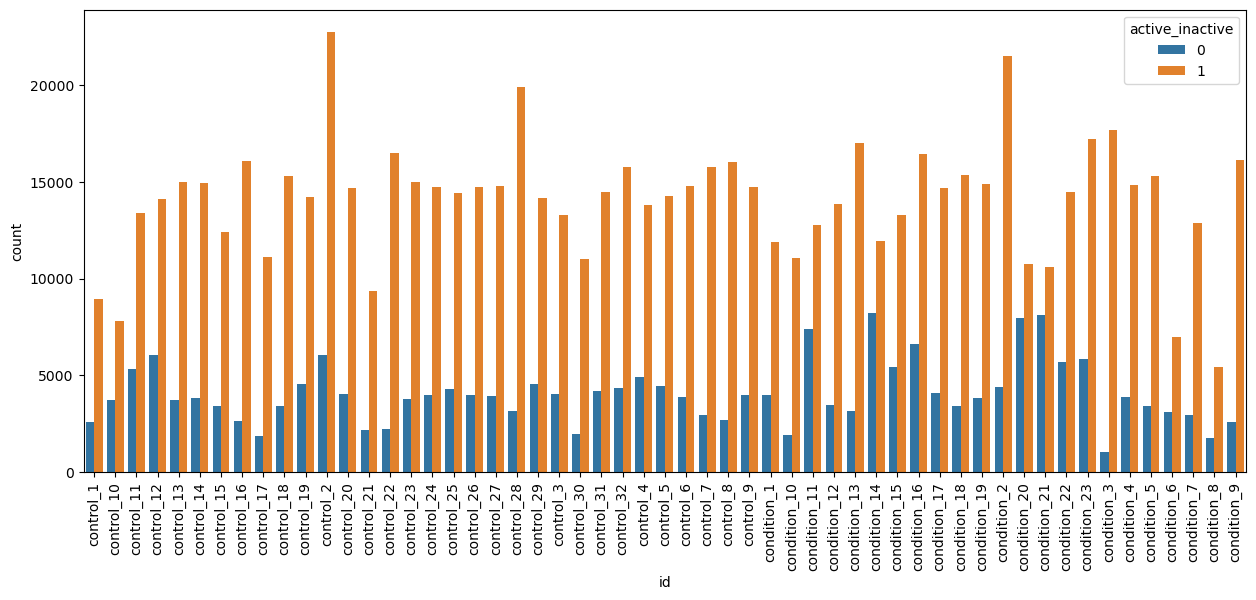

In [18]:
plt.figure(figsize=(15, 6))

sns.countplot(data=trueDates_df, x='id', hue='active_inactive')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Read in sunlight data obtain from the website
# Sunrise and sunset by month for Oslo 
# 'https://www.worlddata.info/europe/norway/sunset.php'

sunlight = pd.read_csv('data/depresjon/Norway_Sunlight.csv')

In [41]:
sunlight

,month,sunrise,sunset
0,1,09:01,15:50
1,2,07:53,17:08
2,3,06:29,18:21
3,4,05:56,20:37
4,5,04:35,21:51
5,6,03:50,22:44
6,7,04:19,22:26
7,8,05:30,21:11
8,9,06:44,19:39
9,10,07:55,18:09


In [42]:
trueDates_df['time'] = pd.to_datetime(trueDates_df['timestamp']).dt.time
trueDates_df['month'] = pd.to_datetime(trueDates_df['timestamp']).dt.month

In [43]:
trueDates_df.head()

,timestamp,date,activity,id,label,day_night,active_inactive,time,month
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0,1,0,00:00:00,3
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0,1,0,00:01:00,3
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0,1,0,00:02:00,3
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0,1,1,00:03:00,3
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0,1,1,00:04:00,3


In [65]:
merged_df = trueDates_df.copy()
merged_df = pd.merge(merged_df, sunlight, on='month', how='inner')

In [68]:
# Function to clasify each row of data as either light (0) or dark (1) 

def light_dark(dataframe):
            
    sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
    sunset = pd.to_datetime(dataframe['sunset']).dt.time
    
    time = dataframe['time']
    
    size1 = len(sunrise)
    
    light_dark = []
    
    for n in range (0,size1):
        if sunrise[n] <= time[n] < sunset[n]:
            light_dark.append(0)
        else:
            light_dark.append(1)
    
    dataframe['light_dark'] = light_dark
    
    dataframe.drop(['time','month','sunrise','sunset'], axis=1, inplace=True)
    
    
    return(dataframe)
    

light_dark(merged_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_41412\1786927293.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
C:\Users\44778\AppData\Local\Temp\ipykernel_41412\1786927293.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunset = pd.to_datetime(dataframe['sunset']).dt.time


,timestamp,date,activity,id,label,day_night,active_inactive,light_dark
0,2003-03-19 00:00:00,2003-03-19,0,control_1,0,1,0,1
1,2003-03-19 00:01:00,2003-03-19,0,control_1,0,1,0,1
2,2003-03-19 00:02:00,2003-03-19,0,control_1,0,1,0,1
3,2003-03-19 00:03:00,2003-03-19,0,control_1,0,1,1,1
4,2003-03-19 00:04:00,2003-03-19,175,control_1,0,1,1,1
...,...,...,...,...,...,...,...,...
997675,2004-06-09 23:55:00,2004-06-09,169,condition_9,1,1,1,1
997676,2004-06-09 23:56:00,2004-06-09,169,condition_9,1,1,1,1
997677,2004-06-09 23:57:00,2004-06-09,169,condition_9,1,1,1,1
997678,2004-06-09 23:58:00,2004-06-09,169,condition_9,1,1,1,1
